In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:

### Import necessary dependencies
import numpy as np
import pandas as pd
import calendar
import datetime
from dateutil.relativedelta import relativedelta
import category_encoders as ce
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge,Lasso,LassoLarsCV
from  scipy.stats import zscore
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go

In [ ]:
#MEAN ABSOLUTE SCALED ERROR METRICS FUNCTION
def MASE(y_train,y_test,y_hat):
  return (((y_train.shape[0]-1)/y_test.shape[0])*(np.sum(np.abs(y_test-y_hat))))/(np.sum(np.abs(y_train[1:]-y_train[0:-1])))

In [ ]:
### Read all files
trainb=pd.read_csv('/content/contraceptive_logistics_data.csv')
submission_usaid=pd.read_csv('/content/submission_format.csv')
sub_zindi=pd.read_csv('/content/SampleSubmission.csv')
contraceptive_case_data_monthly=pd.read_csv('/content/contraceptive_case_data_monthly.csv')
product=pd.read_csv('/content/product.csv')
service_delivery_site_data=pd.read_csv('/content/service_delivery_site_data.csv')
contraceptive_case_data_annual=pd.read_csv('/content/contraceptive_case_data_annual.csv')

### merge product file and service_delivery_site_data file with contraceptive_logistics_data
trainb=trainb.merge(service_delivery_site_data[['site_code','site_type','site_latitude','site_longitude']],on='site_code')
trainb=trainb.merge(product[['product_code','product_type']],on='product_code')

### Create two columns ID and calendar. ID and calendar will be used later in the creation of the training data and the test data
trainb['ID']=trainb.year.astype(str)+' X '+trainb.month.astype(str)+' X '+trainb['site_code']+' X '+trainb['product_code']
trainb['calendar']=trainb[['year','month']].apply(lambda x:datetime.datetime(x['year'],x['month'],calendar.monthrange(x['year'],x['month'])[1]),axis=1)

In [ ]:
### Calculate monthly stock distribution with respect to each year
stock_distribution_monthly = trainb.groupby(['year','month']).stock_distributed.sum().reset_index()

BIVARIATE **ANALYSIS**

In [ ]:
#plot monthly stock ditribution
plot_data = [
    go.Scatter(
        x=stock_distribution_monthly['month'],
        y=stock_distribution_monthly['stock_distributed'],
    )
]
plot_layout = go.Layout(
        title='Montly stock distributed'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
### Estimate for product per site for each month
Total_stock_distributed =trainb.groupby(['month','district','site_code']).product_code.sum().reset_index()
Total_stock_distributed.rename({'product_code':'Total_product_on_month_basis_for_each_site_code'}, axis=1, inplace=True)

In [ ]:
## A function to return a count for product per site
def count_product(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

Total_stock_distributed['Total_product_persite'] = Total_stock_distributed['Total_product_on_month_basis_for_each_site_code'].apply(lambda x: len(x) - x.count(" "))

In [ ]:
### Divide the series by the total length of fixed string to scale counting
Total_stock_distributed['Total_product_persite']= Total_stock_distributed['Total_product_persite']/7
Total_stock_distributed['Total_product_persite']=Total_stock_distributed['Total_product_persite'].astype(int)

In [ ]:
#Containerize Total product on monthly basis to a new variable Total product
Total_stock_distributed['Total_product']=Total_stock_distributed['Total_product_on_month_basis_for_each_site_code'].map(Total_stock_distributed['Total_product_on_month_basis_for_each_site_code'].value_counts())

In [ ]:
#Merge Stock distribution analysis to exiting data
trainb = pd.merge(Total_stock_distributed, trainb, how="inner", on=["month","site_code","district"])

In [ ]:
### Sort data by year and month
### first of all we sort the dataset by year and month to be sure that all the variables we are going to create will follow the evolution of time
trainb=trainb.sort_values(by=['year','month'],ascending=True)

In [ ]:
trainb['som']=trainb[['stock_initial','stock_received','stock_distributed','stock_adjustment','stock_end']].sum(axis=1)
trainb=trainb.loc[trainb['som']!=0]
trainb=trainb.loc[~((trainb['stock_initial']>0)&(trainb['average_monthly_consumption']>0)&(trainb['stock_distributed']==0))]
trainb=trainb.loc[~((trainb['stock_initial']>0)&(trainb['stock_distributed']==0))]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cl=list(trainb.select_dtypes(include=['float','int']).columns)
cl.remove('year')
cl.remove('month')
cl.remove('site_latitude')
cl.remove('site_longitude')
cl.remove('stock_distributed')
trainb[cl]=scaler.fit_transform(trainb[cl])
trainb['stock_distributed_cop']=trainb['stock_distributed'].copy()

In [ ]:
trainb['ewm']=0
for site in trainb['site_code'].unique():
  for prod in trainb['product_code'].unique():
    trainb.loc[(trainb['site_code']==site)&(trainb['product_code']==prod),'ewm']=\
    trainb.loc[(trainb['site_code']==site)&(trainb['product_code']==prod),'stock_distributed'].ewm(min_periods=3,alpha=.6).mean().fillna(method='bfill').values

In [ ]:
'''trainb['z_score']=np.nan

from scipy import stats

for site in trainb['site_code'].unique():
  for prod in trainb['product_code'].unique():
    trainb.loc[(trainb['site_code']==site)&(trainb['product_code']==prod),'z_score']=stats.zscore(trainb.loc[(trainb['site_code']==site)&(trainb['product_code']==prod),'stock_distributed'])
    trainb.loc[(trainb['site_code']==site)&(trainb['product_code']==prod)&(trainb['calendar']<=datetime.datetime(2019,6,30)),'stock_distributed']=\
    trainb.loc[(trainb['site_code']==site)&(trainb['product_code']==prod)&(trainb['calendar']<=datetime.datetime(2019,6,30)),'ewm']'''

'''trainb=pd.concat([trainb.loc[trainb['calendar']>datetime.datetime(2019,6,30)],
                  trainb.loc[(trainb['calendar']<=datetime.datetime(2019,6,30))&(trainb['z_score'].abs()<=3)]]).reset_index(drop=True)'''

"trainb=pd.concat([trainb.loc[trainb['calendar']>datetime.datetime(2019,6,30)],\n                  trainb.loc[(trainb['calendar']<=datetime.datetime(2019,6,30))&(trainb['z_score'].abs()<=3)]]).reset_index(drop=True)"

In [ ]:
### we calculate the difference between rows for the site_code and product_code and we fill missing values with 0
trainb['diff']=trainb.groupby(['site_code','product_code'])['stock_distributed'].diff()
trainb['diff']=trainb['diff'].fillna(0)

### Calculation of cumulative sum of  "diff" columns site_code and product_code. This is useful to keep information of the evolution of stock_distributed
trainb['cumsum_diff']=trainb.groupby(['site_code','product_code'])['diff'].cumsum()

### Calculation of cumulative sum, cumulative max and cumulative min for stock_distributed for site_code and product_code per year
trainb['cumsum']=trainb.groupby(['year','site_code','product_code'])['stock_distributed'].cumsum()
trainb['cummax']=trainb.groupby(['year','site_code','product_code'])['stock_distributed'].cummax()
trainb['cummin']=trainb.groupby(['year','site_code','product_code'])['stock_distributed'].cummin()

####Counts of unique product; so we could re-group per site on monthly basis
trainb['counts_of_product_code']=trainb['product_code'].map(trainb['product_code'].value_counts())
trainb['Availability_per_site_on_monthly_basis'] =trainb.groupby(['month','district','site_code'])['counts_of_product_code'].cumsum()

In [ ]:
'''tt=pd.DataFrame()
tr=trainb.loc[trainb['calendar']<=datetime.datetime(2019,6,30)]
for s in tr['site_code'].unique():
  for i in tr.loc[tr['site_code']==s,'product_code'].unique():
    X=tr.loc[(tr['site_code']==s)&(tr['product_code']==i)]
    zc=zscore(X[['stock_distributed']])
    abs_z_scores = np.abs(zc)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    new_df = X.loc[filtered_entries]
    tt=pd.concat([tt,new_df]).reset_index(drop=True)

trainb=pd.concat([tt,trainb.loc[trainb['calendar']>datetime.datetime(2019,6,30)]]).reset_index(drop=True)'''

"tt=pd.DataFrame()\ntr=trainb.loc[trainb['calendar']<=datetime.datetime(2019,6,30)]\nfor s in tr['site_code'].unique():\n  for i in tr.loc[tr['site_code']==s,'product_code'].unique():\n    X=tr.loc[(tr['site_code']==s)&(tr['product_code']==i)]\n    zc=zscore(X[['stock_distributed']])\n    abs_z_scores = np.abs(zc)\n    filtered_entries = (abs_z_scores < 3).all(axis=1)\n    new_df = X.loc[filtered_entries]\n    tt=pd.concat([tt,new_df]).reset_index(drop=True)\n\ntrainb=pd.concat([tt,trainb.loc[trainb['calendar']>datetime.datetime(2019,6,30)]]).reset_index(drop=True)"

In [ ]:
#Concatenation of site and product code for relationship between unique product
trainb['site_product_concatenation']= trainb['site_code']+ '_'+trainb['product_code']

In [ ]:
### Our approach is to develop 3 models. If we are at month M, model_1 must predict the value of month M+1,model_2 must predict the value of month M+2
### and model_3 must predict the value of month M+3. With this approach we can predict the value for October, November and December.
### to achieve this we create 3 target variables (stock_distributed_t1,stock_distributed_t2 and stock_distributed_t3). If we are in month M the target variable for model_1 will be
### the value of stock_distributed in month m + 1 we call this variable stock_distributed_t1. The reasoning is the same for stock_distributed_t2 and stock_distributed_t3

trainb['shift_1']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(1)
trainb['shift_2']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(2)

trainb.loc[trainb['shift_1'].isnull(),'shift_1']=trainb.loc[trainb['shift_1'].isnull(),'average_monthly_consumption'].values
trainb.loc[trainb['shift_2'].isnull(),'shift_2']=trainb.loc[trainb['shift_2'].isnull(),'average_monthly_consumption'].values

trainb['stock_distributed_t1']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(-1)
trainb['stock_distributed_t2']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(-2)
trainb['stock_distributed_t3']=trainb.groupby(['site_code','product_code'],sort=False)['stock_distributed'].shift(-3)

### we fill the missing values with average_monthly_consumption columns. This columns gives a better result compared to stock_distributed
trainb.loc[trainb['stock_distributed_t1'].isnull(),'stock_distributed_t1']=trainb.loc[trainb['stock_distributed_t1'].isnull(),'average_monthly_consumption'].values
trainb.loc[trainb['stock_distributed_t2'].isnull(),'stock_distributed_t2']=trainb.loc[trainb['stock_distributed_t2'].isnull(),'average_monthly_consumption'].values
trainb.loc[trainb['stock_distributed_t3'].isnull(),'stock_distributed_t3']=trainb.loc[trainb['stock_distributed_t3'].isnull(),'average_monthly_consumption'].values

trainb['rolling_mean']=trainb[['shift_1','shift_2','stock_distributed']].mean(axis=1)

In [ ]:
### here we create aggregate feature mean,median and std
### we create a dictionnary to map  key columns with the columns we are going to aggregate

grp={'month,region,product_code':['stock_initial','stock_received','rolling_mean'],'month,district,product_code':['stock_initial','stock_received','rolling_mean'],
     'month,district,site_code,product_code':['stock_initial','stock_received','rolling_mean'],
     'month,region,product_type':['stock_initial','stock_received','rolling_mean',],'month,district,product_type':['stock_initial','stock_received','rolling_mean'],
     'month,district,site_code,product_type':['stock_initial','stock_received','rolling_mean'],
     'region,product_code':['stock_initial','stock_received','rolling_mean'],'district,product_code':['stock_initial','stock_received','rolling_mean'],
     'district,site_code,product_code':['stock_initial','stock_received','rolling_mean'],
     'region,product_type':['stock_initial','stock_received','rolling_mean'],'district,product_type':['stock_initial','stock_received','rolling_mean'],
     'district,site_code,product_type':['stock_initial','stock_received','rolling_mean']}

In [ ]:
### we process the aggregation
for g in grp:
  dic={}
  for j in grp[g]:
    dic[j]=[np.mean,np.median,np.std]
  pp=trainb.groupby(g.split(',')).agg(dic).reset_index()
  pp.columns=[c[0] if c[1]=='' else g+'_'+c[0]+'_'+c[1] for c in pp.columns]
  trainb=trainb.merge(pp,on=g.split(','))

In [ ]:
test=trainb.loc[trainb['calendar']<=datetime.datetime(2019,6,30)].sort_values(by=['year','month'],ascending=True).drop_duplicates(subset=['site_code','product_code'],keep='last')
train=trainb.loc[~trainb['ID'].isin(test['ID'].values)]
train=train.loc[train['calendar']<=datetime.datetime(2019,6,30)]

In [ ]:
### We make a one hot encoding for some categorical columns and we remove unnecessary variables
enc=ce.OneHotEncoder(cols=['region','district','product_code','site_type','product_type','site_product_concatenation'],drop_invariant=True,use_cat_names=True)
d_train=enc.fit_transform(train)
d_test=enc.transform(test)
col=list(d_train.columns)
col.remove('year')

col.remove('site_code')
col.remove('stock_ordered')
col.remove('stock_received')

col.remove('shift_1')
col.remove('shift_2')

col.remove('calendar')

col.remove('stock_initial')
col.remove('stock_adjustment')
col.remove('stock_stockout_days')

col.remove('stock_distributed')
col.remove('stock_distributed_t1')
col.remove('stock_distributed_t2')
col.remove('stock_distributed_t3')
col.remove('average_monthly_consumption')
col.remove('ID')
col.remove('diff')
#col.remove('z_score')
col.remove('stock_distributed_cop')
col.remove('ewm')
col.remove('som')
#col.remove('cumsum')
col.remove('Total_product_on_month_basis_for_each_site_code')

In [ ]:
#Initializing models. model1+ls1 will be used to predict October, model2+ls2 will be used to predict November and so on
model1=LGBMRegressor(max_depth=4,learning_rate=0.03,n_estimators=3000,verbosity=1,silent=None,objective='regression',
                   booster='gbtree',n_jobs=-1,subsample=.5,colsample_bytree=.5,random_state=1993)
model2=LGBMRegressor(max_depth=4,learning_rate=0.03,n_estimators=3000,verbosity=1,silent=None,objective='regression',
                   booster='gbtree',n_jobs=-1,subsample=.5,colsample_bytree=.5,random_state=1993)
model3=LGBMRegressor(max_depth=4,learning_rate=0.03,n_estimators=3000,verbosity=1,silent=None,objective='regression',
                   booster='gbtree',n_jobs=-1,subsample=.5,colsample_bytree=.5,random_state=1993)


rdg=Lasso(alpha=1.5,normalize=False,random_state=42)


In [ ]:
### create 3 variables for the target label et 3 columns in test set to receive models prediction
y1='stock_distributed_t1'
y2='stock_distributed_t2'
y3='stock_distributed_t3'

In [ ]:
d_test['predicted1']=0
d_test['predicted2']=0
d_test['predicted3']=0

In [ ]:
### For each target select best features with ExtraTreesRegressor and store this features in dictionnary
clf = ExtraTreesRegressor(n_estimators=1000,max_depth=10,random_state=42)

cl={}
for y in [y1,y2,y3]:
  '''clf.fit(d_train[col].fillna(0), d_train[y])
  model = SelectFromModel(clf, prefit=True,threshold='median')
  cl[y]=list(np.array(col)[model.get_support()])'''
  cl[y]=col

In [ ]:
### train first model with selected feature and combine the predictions 
x_tr,y_tr=d_train.loc[d_train['calendar']<=datetime.datetime(2019,5,31),cl[y1]],d_train.loc[d_train['calendar']<=datetime.datetime(2019,5,31),y1]
model1.fit(x_tr,y_tr)
rdg.fit(x_tr.fillna(0),y_tr)
d_test['predicted1']=np.round(model1.predict(d_test[cl[y1]])*.75+rdg.predict(d_test[cl[y1]].fillna(0))*.25)

In [ ]:
### train second model with selected feature and combine the predictions
x_tr,y_tr=d_train.loc[d_train['calendar']<=datetime.datetime(2019,4,30),cl[y2]],d_train.loc[d_train['calendar']<=datetime.datetime(2019,4,30),y2]
model2.fit(x_tr,y_tr)
rdg.fit(x_tr.fillna(0),y_tr)
d_test['predicted2']=np.round(model2.predict(d_test[cl[y2]])*.75+rdg.predict(d_test[cl[y2]].fillna(0))*.25)

In [ ]:
### train third model with selected feature and combine the predictions
x_tr,y_tr=d_train.loc[d_train['calendar']<=datetime.datetime(2019,3,31),cl[y3]],d_train.loc[d_train['calendar']<=datetime.datetime(2019,3,31),y3]
model3.fit(x_tr,y_tr)
rdg.fit(x_tr.fillna(0),y_tr)
d_test['predicted3']=np.round(model3.predict(d_test[cl[y3]])*.75+rdg.predict(d_test[cl[y3]].fillna(0))*.25)

In [ ]:
d_test['site_code']=d_test['ID'].str.split('X',expand=True)[2].str.strip()
d_test['product_code']=d_test['ID'].str.split('X',expand=True)[3].str.strip()
aux=d_test.sort_values(by=['year','month'])
aux.drop_duplicates(subset=['site_code','product_code'],keep='last',inplace=True)

aux['ID']=aux.year.astype(str)+' X '+'7'+' X '+aux['site_code']+' X '+aux['product_code']
a=pd.DataFrame({'ID':aux['ID'].values,'prediction':aux['predicted1'].values})

aux=d_test.sort_values(by=['year','month'])
aux.drop_duplicates(subset=['site_code','product_code'],keep='last',inplace=True)
aux['ID']=aux.year.astype(str)+' X '+'8'+' X '+aux['site_code']+' X '+aux['product_code']
b=pd.DataFrame({'ID':aux['ID'].values,'prediction':aux['predicted2'].values})

aux=d_test.sort_values(by=['year','month'])
aux.drop_duplicates(subset=['site_code','product_code'],keep='last',inplace=True)
aux['ID']=aux.year.astype(str)+' X '+'9'+' X '+aux['site_code']+' X '+aux['product_code']
c=pd.DataFrame({'ID':aux['ID'].values,'prediction':aux['predicted3'].values})

dd=pd.concat([a,b,c]).reset_index(drop=True)

In [ ]:
zindi_sub=trainb[['ID','stock_distributed_cop']].merge(dd,on='ID',how='left')
zindi_sub=zindi_sub.loc[(zindi_sub['ID'].str.startswith('2019 X 7',na=False))|(zindi_sub['ID'].str.startswith('2019 X 8',na=False))|(zindi_sub['ID'].str.startswith('2019 X 9',na=False))]
zindi_sub.fillna(0,inplace=True)
zindi_sub.loc[zindi_sub['prediction']<0,'prediction']=-1*zindi_sub.loc[zindi_sub['prediction']<0,'prediction'].values

mase=[]
for site in trainb['site_code'].unique():
  for prod in trainb['product_code'].unique():
    y_train=trainb.loc[(trainb['site_code']==site)&(trainb['product_code']==prod)&(trainb['calendar']<=datetime.datetime(2019,6,30))].sort_values(['year','month'])['stock_distributed_cop'].values
    y_test=zindi_sub.loc[(zindi_sub['ID'].str.contains(site+' X '+prod,na=False)),'stock_distributed_cop'].values
    y_hat=zindi_sub.loc[(zindi_sub['ID'].str.contains(site+' X '+prod,na=False)),'prediction'].values

    if (y_train.shape[0]>0)&(y_test.shape[0]>0)&(np.sum(np.abs(y_train[1:]-y_train[0:-1]))>0):
      mase.append(MASE(y_train,y_test,y_hat))
      
np.mean(mase)

0.8764826789212969

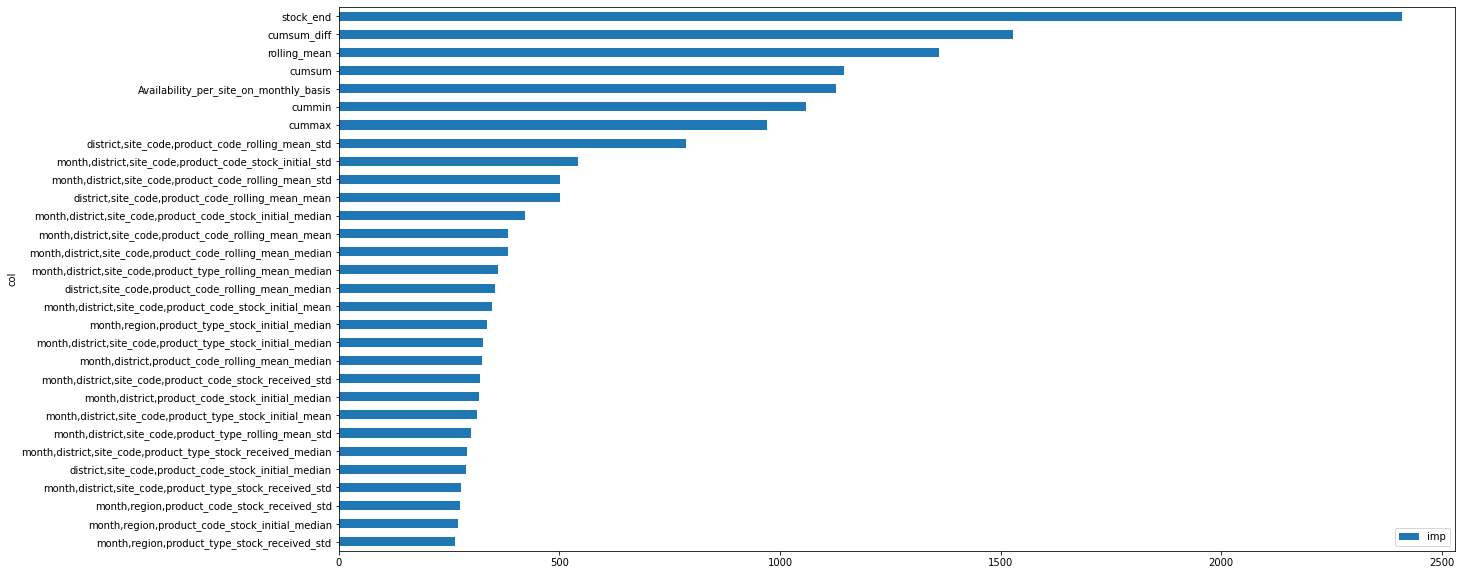

In [ ]:
fea_imp = pd.DataFrame({'imp':model1.feature_importances_, 'col': x_tr.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))   

In [ ]:
zindi_sub[['ID','prediction']].to_csv('usaid_baseline1.csv',index=False)